# Ensemble of deep neural networks

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from dynamax.utils import datasets
from flax.training.train_state import TrainState

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## The model

In [4]:
class MLP(nn.Module):
    dim_out: int
    activation: Callable = nn.relu
        
    @nn.compact
    def __call__(self, x):
        # Shared components
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        
        return x

In [5]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

## Rotating MNIST

## Setup

In [6]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=1, maxangle=180)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


# X_train = X_train.reshape(-1, 28, 28)
# X_test = X_test.reshape(-1, 28, 28)
num_train, *dim_input = X_train.shape

# Introducing trenches
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

y_train = y_train[map_trench]
X_train = X_train[map_trench]

In [7]:
batch_size = 100
batch = (batch_size, *dim_input)
model = MLP(1, activation=nn.elu)
batch = jnp.ones(batch)

params_init = model.init(key_init, batch)

### Training

In [8]:
import optax
from rebayes import batch_sgd as bsgd

In [9]:
from tqdm.notebook import tqdm

In [10]:
num_epochs = 1000
batch_size = 500
keys_train = jax.random.split(key_train, num_epochs)
loss_grad = jax.value_and_grad(bsgd.lossfn, 0)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(5e-5)
)

losses = []
crossval = []

elements  = list(enumerate(keys_train))
pbar = tqdm(elements)
for (e, key) in pbar:
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train, loss_grad)
    losses.append(loss)
    
    xv_test = bsgd.lossfn(state.params, X_test, y_test, state.apply_fn)
    crossval.append(xv_test.item())

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/1000 [00:00<?, ?it/s]

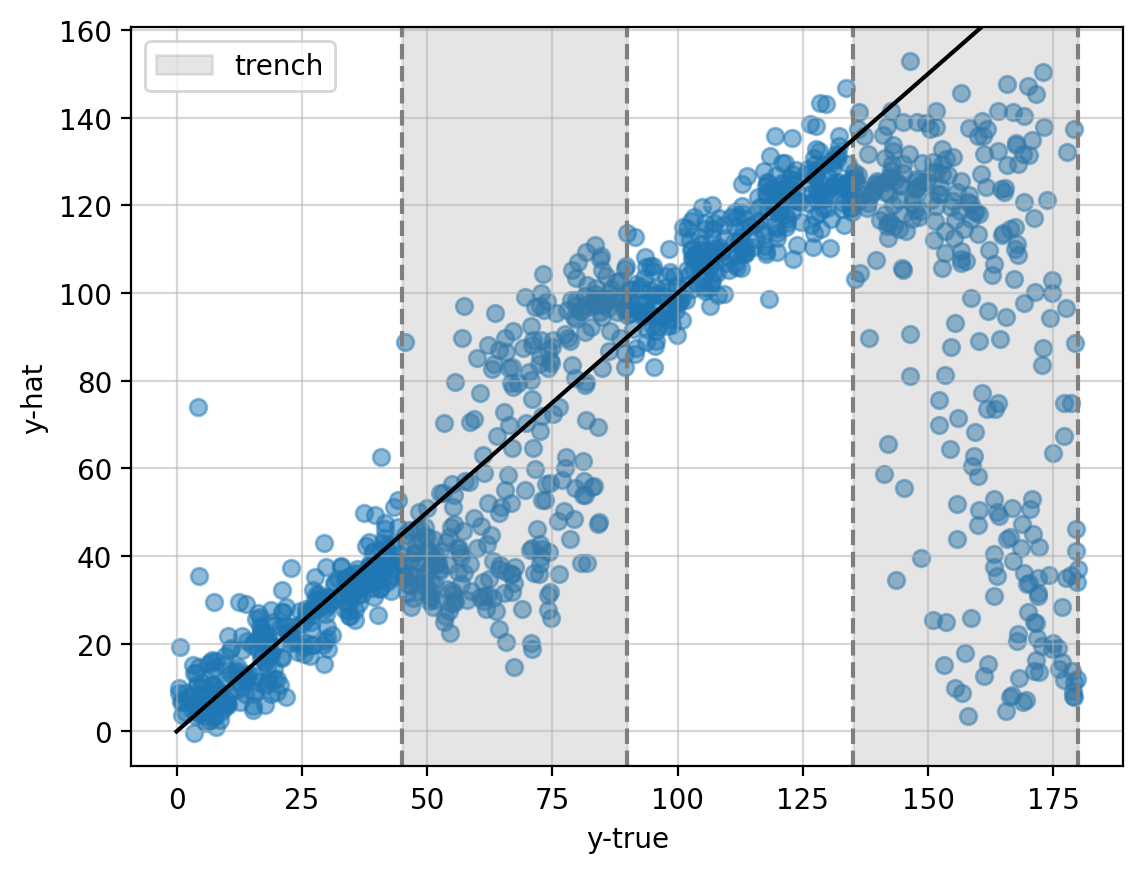

In [20]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)
vmin, vmax = y_test.min(), y_test.max()
yhat_test = state.apply_fn(state.params, X_test).ravel()

plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)

plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

## Ensemble

In [21]:
from jax.flatten_util import ravel_pytree

In [39]:
def create_train_state(params):
    state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optax.adam(5e-5)
    )
    return state


def step_train(state, key):
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train, loss_grad)
    xv_test = bsgd.lossfn(state.params, X_test, y_test, state.apply_fn)    
    return state, xv_test


def init_and_train(key):
    num_epochs = 1000
    key_init, key_train = jax.random.split(key)
    params_init = model.init(key_init, batch)
    
    params_flat, rfn = ravel_pytree(params_init)
    n_params = len(params_flat)
    params_init = jax.random.normal(key, (n_params,)) / 2
    params_init = jnp.clip(params_init, -2.5, 2.5)
    params_init = rfn(params_init)
    
    
    state = create_train_state(params_init)
    keys_train = jax.random.split(key_train, num_epochs)
    state, crossval = jax.lax.scan(step_train, state, keys_train)
    return state, crossval

## Train ensemble

In [40]:
%%time
key_vtrain = jax.random.split(key, 100)
state, crossval = jax.vmap(init_and_train)(key_vtrain)
crossval = jax.block_until_ready(crossval)

CPU times: user 1min 19s, sys: 6.91 s, total: 1min 26s
Wall time: 1min 12s


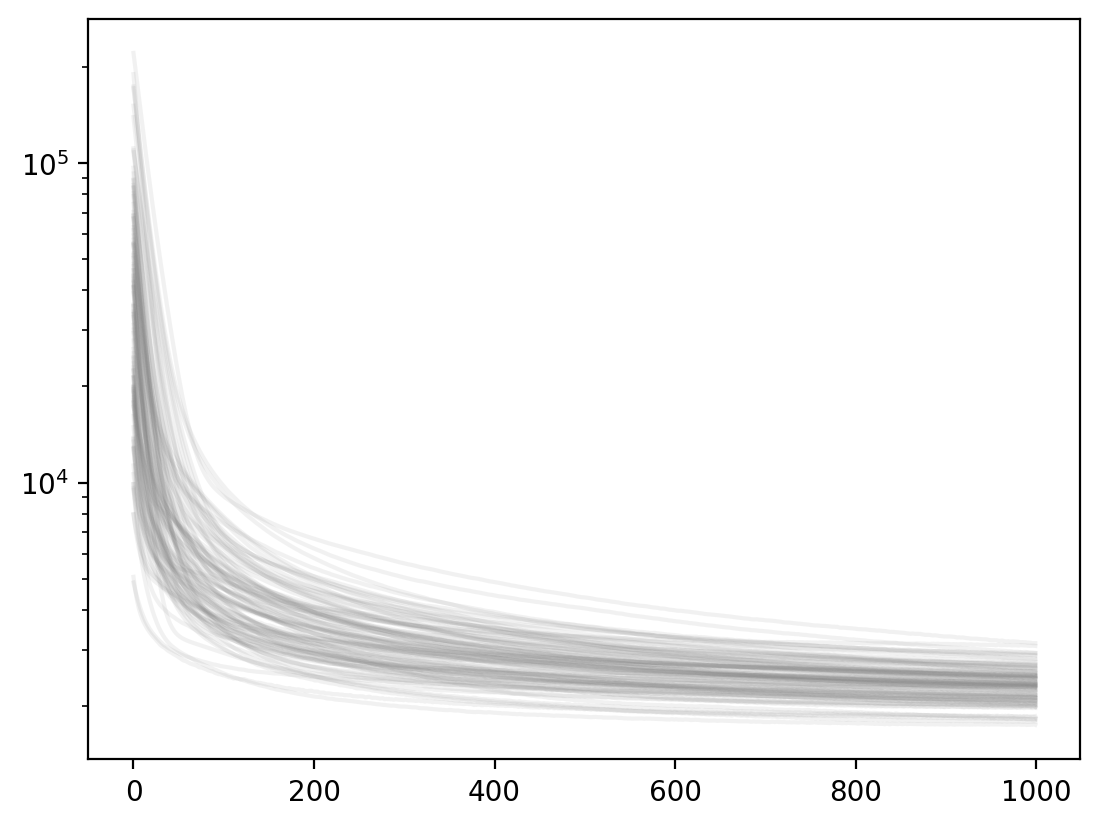

In [41]:
plt.plot(crossval.T, c="tab:gray", alpha=0.1)
plt.yscale("log")

In [42]:
yhat_samples = jax.vmap(state.apply_fn, (0, None))(state.params, X_test)
yhat_test = yhat_samples.mean(axis=0).ravel()
yhat_std = yhat_samples.std(axis=0).ravel()

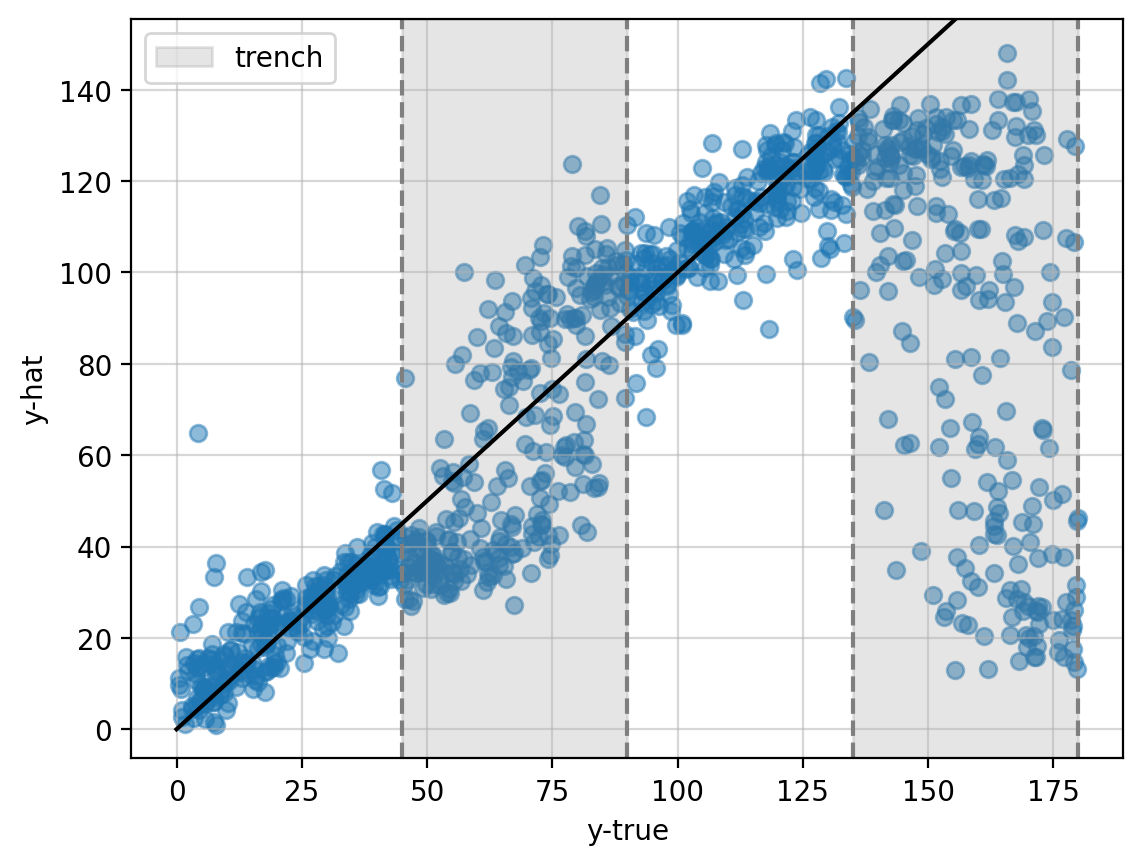

In [43]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)

plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

### Evaluating the posterior predictive as a function of rotation angle

In [44]:
ix_target = 0
x_target = np.array(X_test[ix_target]).reshape(28, 28)
y_init = float(y_test[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

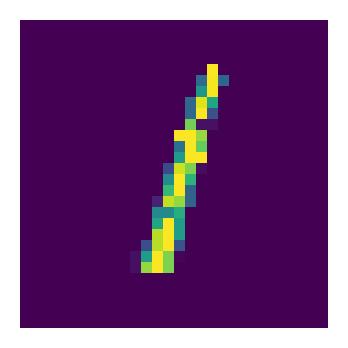

In [45]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

In [46]:
n_rotations = 1000
rotations = np.linspace(0, 360, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 360, 100)

In [47]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [48]:
%%time
yhat_samples = jax.vmap(state.apply_fn, (0, None))(state.params, X_target).squeeze()

CPU times: user 101 ms, sys: 302 µs, total: 101 ms
Wall time: 85.6 ms


In [49]:
yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

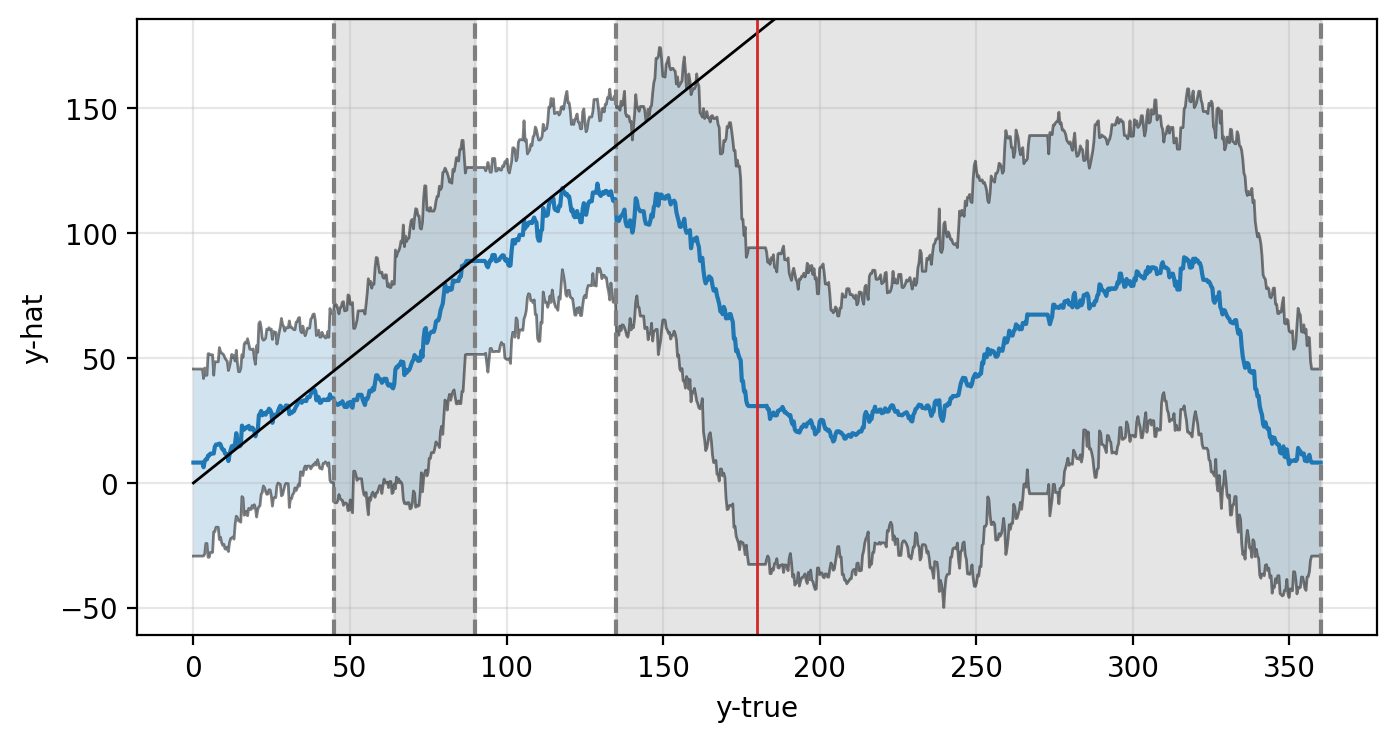

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 360], [0, 360], c="black", linewidth=1)
plt.ylim(ymin, ymax)

plt.axvline(x=180, c="tab:red", linewidth=1)

plt.grid(alpha=0.3)

## Estimating uncertainty

Based on [Ciosek20](https://openreview.net/forum?id=BJlahxHYDS).

Uncertainty of an ensemble DNN is estimated as

$$
    \hat\sigma^2(x) = \max(0, \hat{\sigma}^2_\mu(x) + \beta \hat{v}(x) - \sigma^2_A),
$$

where
* $\hat\sigma^2_\mu(x) := \frac{1}{B}\sum_{b=1}^B ||f(x) - h_{{\cal X}f_b}(x)||^2$ is the sample mean of the squared error.
* $v_\sigma(x) := \left[\frac{1}{B}\sum\left(\hat\sigma^2_\mu(x) - ||f(x) - h_{{\cal X}f_b}(x)||^2\right)\right]^{1/2}$ is the sample-based estimate of the standard deviation of squared error accross bootstraps 
* $f(x)$ is the prior process
* $h_{{\cal X}f_b}(x)$ is the $b$-th element in the ensemble
* $\beta$ controls the degree to which $\hat v_\sigma(x)$ is taken into account.
* $B$ is the number of elements in the ensemble
* $\sigma^2_A$ is the amount of aleatoric uncertainty

In [51]:
e_mean = y_train.mean()
e_var = y_train.var()

diff2 = (e_mean - yhat_samples) ** 2
sigma_mu = diff2.mean(axis=0)

eta_sigma = jnp.sqrt(((sigma_mu - diff2) ** 2).mean(axis=0))

y_uncert = jnp.maximum(0, sigma_mu + 1/2 * eta_sigma - e_var)
y_uncert = jnp.sqrt(y_uncert)

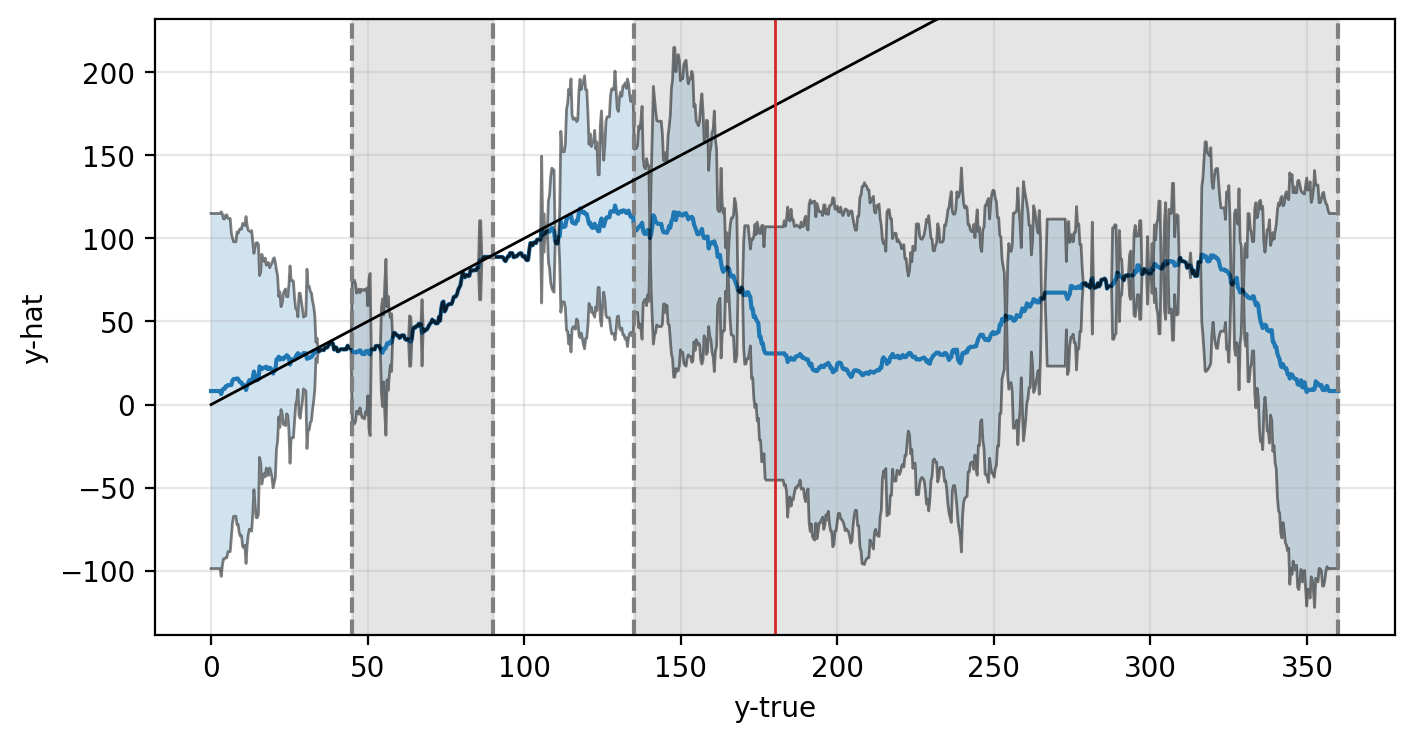

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * y_uncert
ubound = yhat_mean + 1.96 * y_uncert
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 360], [0, 360], c="black", linewidth=1)
plt.ylim(ymin, ymax)

plt.axvline(x=180, c="tab:red", linewidth=1)

plt.grid(alpha=0.3)